In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eigh
from scipy.integrate import solve_ivp, odeint, quad
from scipy.optimize import minimize, linprog
from scipy.special import lambertw
from math import ceil

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Linear Programming

\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & c^\top x, \\
\text{s.t.} \quad & Ax \leq b.
\end{aligned}

In [ ]:
# Define the coefficients of the objective function c
# Define the coefficients for the inequality constraints: Ax <= b

'''
# PROBLEM 1
c_lp = np.array([2, -3])
A_lp = np.array([[1, 1], [-1, 0], [0, -1]])
b_lp = np.array([1, 0, 0])
'''


# PROBLEM 2
c_lp = np.array([1, 1, 1])
A_lp =  np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, 0, 0], [0, -1, 0], [0, 0, -1]])
b_lp =  np.array([1, 1, 1, 1, 1, 1])


'''
# PROBLEM 3
c_lp = np.array([6, 3, 4])
A_lp_trp = np.array([[4, -7, -1, -1, 0, 1],
                     [-3, -1, 0, -1, 0, 1],
                     [-3, 2, 0, 0, -1, 1]])
A_lp = A_lp_trp.T
b_lp = np.array([-2, -6, 0, 0, 0, 5])
'''

# Solve the linear program
result_lp = linprog(c=c_lp, A_ub=A_lp, b_ub=b_lp, bounds=(None, None))

if result_lp.success:
    print("Optimal solution found:")
    print("Objective function value:", result_lp.fun)
    print("Optimal values for x:", result_lp.x)
else:
    print("Optimization failed. Check constraints or the problem formulation.")

In [3]:
def relu(x):
    return np.maximum(0, x)

def der_relu(x):
    return np.where(x > 0, 1, 0)

In [4]:
def dynamics_lp(t, z, c, A, b, gamma):
    """
    Continuous-time augmented primal-dual dynamics:
             \dot x = - c - 1/gamma(A^T ReLU(Ax + gamma \lambda - b))
       \dot \lambda = - gamma \lambda + ReLU( Ax + gamma \lambda - b)
       INPUT:
       -     c = coefficients of the objective function
       -     A = matrix for the inequality constraints
       -     b = vector RHS the inequality constraints
       - gamma = positive parameter
    """
    n = A.shape[1]
    x, lam = z[:n], z[n:]
    y = A @ x + gamma * lam
    dxdt   = - c - (1/gamma) * A.T @ relu(y - b)
    dlamdt = - gamma * lam + relu(y - b)
    return np.concatenate([dxdt, dlamdt])

def euler_step(dynamics, t, z, dt, *args):
    """
    Perform a single step of Euler's method.
    INPUT:
        dynamics = function that defines the ODE
               t = Current time -- float
               z = Current state -- array_like
              dt = Time step size -- float
            args = Any additional arguments to pass to the dynamics function -- tuple
    OUTPUT:
        The state after a single Euler step -- array_like
    """
    return z + dt * dynamics(t, z, *args)

In [5]:
n_lp = A_lp.shape[1]       # number of columns of the matrix A_lp
m_lp = A_lp.shape[0]       # number of rows of the matrix A_lp


# Define initial time (ti_lp) and final time (tf_lp) for the simulation
ti_lp = 0
tf_lp = 40

gamma = 0.5
dt = 0.001                 # time step size for Euler's method
t_lp_eul = np.arange(ti_lp, tf_lp, dt)          # time points from initial time (ti_lp) to final time (tf_lp) with a time step (dt)
initial_conditions_lp = np.zeros(n_lp + m_lp)   # initial conditions for the variables (x) and Lagrange multipliers (lambda)

In [6]:
# Create an array to store the solution of the dynamics over time, where each row corresponds to a time step
# and each column corresponds to a variable or Lagrange multiplier
sol_lp = np.zeros((len(t_lp_eul), n_lp + m_lp))
sol_lp[0, :] = initial_conditions_lp
for i in range(1, len(t_lp_eul)):
    # Use Euler's method to compute the state at the current time step based on the dynamics
    sol_lp[i, :] = euler_step(dynamics_lp, t_lp_eul[i-1], sol_lp[i-1, :], dt, c_lp, A_lp, b_lp, gamma)

x_values_lp = sol_lp[:, :n_lp]         # Extract the values of x over time from the solution array
lam_values_lp = sol_lp[:, n_lp:]       # Extract the values of lambda over time from the solution array

equilibrium_point = sol_lp[-1, :]

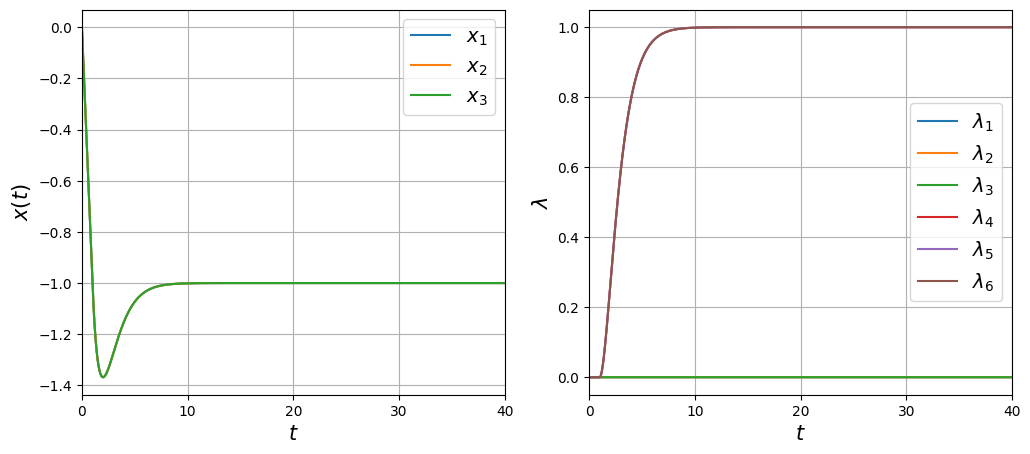

In [7]:
# Create a figure with two subplots side by side:
#  Left: Values of x over time
# Right: Values of lambda over time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
plt.rcParams.update({'font.size': 14})

for i in range(n_lp):
    ax1.plot(t_lp_eul, x_values_lp[:, i], label=f"$x_{i+1}$")
ax1.set_xlabel(r'$t$', fontsize=15)
ax1.set_ylabel(r'$x(t)$', fontsize=15)
ax1.set_xlim(left=0, right=tf_lp)
x_ticks = np.linspace(0, 15, 6)
ax1.legend()
ax1.grid(True)

for i in range(m_lp):
    ax2.plot(t_lp_eul, lam_values_lp[:, i], label=f"$\lambda_{i+1}$")
ax2.set_xlabel(r'$t$', fontsize=15)
ax2.set_ylabel(r'$\lambda$', fontsize=15)
ax2.set_xlim(left=0, right=tf_lp)
ax2.legend()
ax2.grid(True)
plt.show()

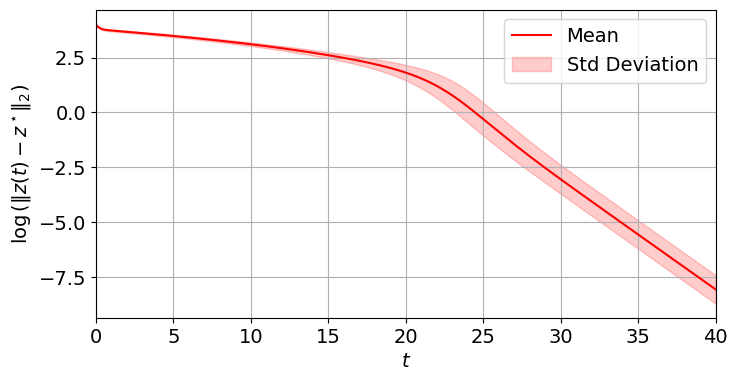

In [18]:
log_norms = []
#initial_conditions_lp_rnd = 50*np.random.rand(n_lp + m_lp)
#FOR PROBLEM 2
initial_conditions_lp_rnd = np.array([10, 15, 25, 20, 5, 10, 30, 15, 20])
for _ in range(150):
   initial_conditions_lp_rnd_eps = initial_conditions_lp_rnd + np.random.normal(0, 2, n_lp + m_lp)
   sol_lp_rnd = np.zeros((len(t_lp_eul), n_lp + m_lp))
   sol_lp_rnd[0, :] = initial_conditions_lp_rnd_eps
   for i in range(1, len(t_lp_eul)):
      sol_lp_rnd[i, :] = euler_step(dynamics_lp, t_lp_eul[i-1], sol_lp_rnd[i-1, :], dt, c_lp, A_lp, b_lp, gamma)
   norm_rnd = np.linalg.norm(sol_lp_rnd - equilibrium_point, 2, axis=1)
   log_norm_rnd = np.log(norm_rnd)
   log_norms.append(log_norm_rnd)

# Compute mean and confidence bounds
log_norms = np.array(log_norms)
mean_log_norm = np.mean(log_norms, axis=0)
std_dev_log_norm = np.std(log_norms, axis=0)
upper_bound = mean_log_norm + std_dev_log_norm
lower_bound = mean_log_norm - std_dev_log_norm

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t_lp_eul, mean_log_norm, 'r', linewidth = 1.5, label='Mean')
plt.fill_between(t_lp_eul, lower_bound, upper_bound, color='r', alpha=0.2, label='Std Deviation')
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r"$\log\left(\|z(t) - z^\star \|_{2}\right)$", fontsize=14)
plt.xlim(left=0, right=tf_lp)
plt.grid(True)
plt.legend()
plt.savefig(f'/content/drive/My Drive/lin_exp_bound/lin_prog_log_2.pdf', bbox_inches='tight')
plt.show()

Chech if $D F_{\operatorname{LP}}(x^\star, \lambda^\star)$ is Hurwitz.

In [10]:
def J_eq(A, b, gamma, x_star, lambda_star):
    """
    Calculate the Jacobian matrix of the dynamics AT (x_star, lambda_star).
    INPUT:
                  A = Matrix for the inequality constraints
                  b = Vector RHS of the inequality constraints
              gamma = Positive parameter
             x_star = Equilibrium values of X
        lambda_star = Equilibrium values of lambda
    OUTPUT:
        jac_eq: Jacobian matrix computed at equilibrium equations
    """
    Ax_lambda_b = np.dot(A, x_star) + gamma * lambda_star - b      # Calculate A x^star + gamma \lambda^\star - b
    der_relu_Ax_lambda_b = der_relu(Ax_lambda_b)                   # Calculate the derivative of ReLU function at Ax_lambda_b
    D_relu_Ax_lambda_b = np.diag(der_relu_Ax_lambda_b)             # Create a diagonal matrix with derivative of ReLU function at Ax_lambda_b as diagonal elements
    m, n = A.shape
    top_left = - (1 / gamma) * np.dot(np.dot(A.T, D_relu_Ax_lambda_b), A)
    top_right = - np.dot(A.T, D_relu_Ax_lambda_b)
    bottom_left = np.dot(D_relu_Ax_lambda_b, A)
    bottom_right = - gamma * (np.eye(m) - D_relu_Ax_lambda_b)

    top = np.concatenate((top_left, top_right), axis=1)
    bottom = np.concatenate((bottom_left, bottom_right), axis=1)
    jac_eq = np.concatenate((top, bottom), axis=0)
    return jac_eq

In [11]:
x_star = x_values_lp[-1,:]
lambda_star = lam_values_lp[-1,:]
print(f"x_star = {x_star}")
print(f"lambda_star = {lambda_star}")

# Calculate the Jacobian at the equilibrium
jac_eq = J_eq(A_lp, b_lp, gamma, x_star, lambda_star)

eigenvalues_jac = np.linalg.eigvals(jac_eq)                         # Compute the eigenvalues of the Jacobian matrix
print("Eigenvalues of jac:", eigenvalues_jac)

x_star = [-1. -1. -1.]
lambda_star = [0. 0. 0. 1. 1. 1.]
Eigenvalues of jac: [-1.  -1.  -1.  -1.  -1.  -1.  -0.5 -0.5 -0.5]
